In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
#matplotlib.rcParams['figure.figsize'] = (7.0, 5.5)

from astropy import units
from galpy.orbit import Orbit
from FerrersPotential import FerrersPotential as FP
from galpy.potential import PlummerPotential as PP

In [3]:
%%prun -s cumulative
pmw = FP(amp = 1, a = 8*units.kpc, b = 0.35, c = 0.2375, normalize = True, omegab = 10.*units.km/units.s/units.kpc)
ts = np.linspace(0,34,500)
omwa = Orbit(vxvv=[1,0.25,0.7,0,0.0,0]) #[R,vR,vT,z,vz,phi]
omwb = Orbit(vxvv=[1,0.25,0.7,0,0.0,0]) #[R,vR,vT,z,vz,phi]

omwa.integrate(ts, pmw, method = 'leapfrog')
omwb.integrate(ts, ps, method = 'leapfrog')

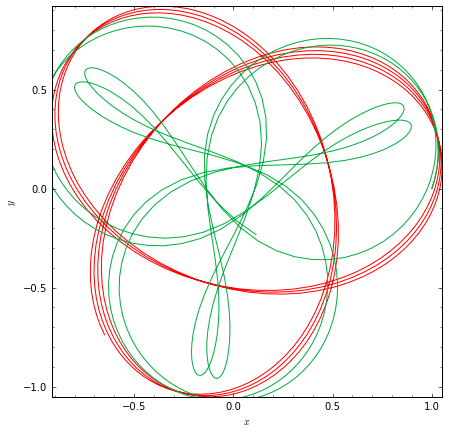

In [7]:
matplotlib.rcParams['figure.figsize'] = (7,7)
omwb.plot(d1 = 'x', d2 = 'y', overplot = False, color = 'red')
omwa.plot(d1 = 'x', d2 = 'y', overplot = True, color = '#00AF3F')

In [192]:
ts = np.linspace(0,500,5000)
omwf = Orbit(vxvv=[1,0.25,0.6,0,0.0,0]) #[R,vR,vT,z,vz,phi]

omwf.integrate(ts, pmw, method = 'leapfrog')

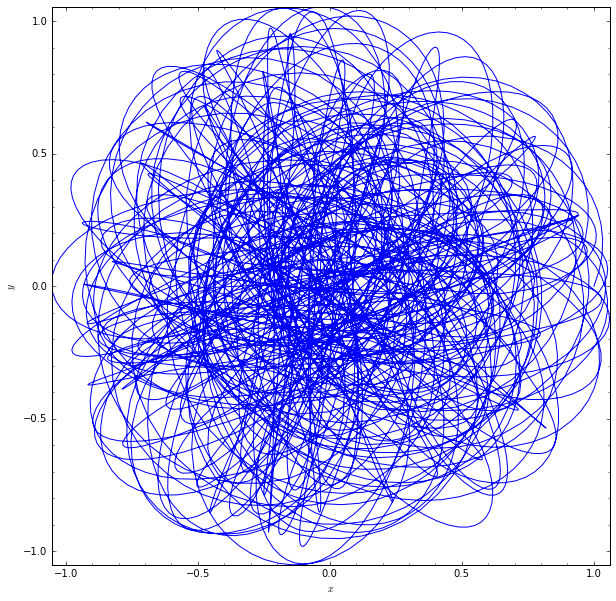

In [193]:
omwf.plot(d1 = 'x', d2 = 'y')

In [552]:
omwg.integrate(ts, ps, method = 'leapfrog')

# ======================  useful functions  =========================

In [123]:
def rot(omega, t):
    temp = [[np.cos(t*omega), np.sin(t*omega)], [-np.sin(t*omega), np.cos(t*omega)]]
    return np.array(temp)

def inrotframe(x,y, ts, potential):
    xy = np.zeros([len(x),2])
    xy[:,0] = x
    xy[:,1] = y
    omega = potential.OmegaP()
    xrot, yrot = np.zeros(len(ts)), np.zeros(len(ts))
    for i in range(len(ts)):
        xrot[i],yrot[i] = np.dot(xy[i],rot(omega, ts[i]))
    return xrot, yrot

In [99]:
def allorbits(x,y):
    xo = [x[4*i] for i in range(int(len(x)/4))]
    xo1 = [x[4*i+1] for i in range(int(len(x)/4))]
    yo = [y[4*i] for i in range(int(len(x)/4))]
    yo1 = [y[4*i+1] for i in range(int(len(x)/4))]
    return [xo,yo],[xo1,yo1]

# =====================  Lyapunov exponent  =======================

In [ ]:
xle,yle = [],[]

In [202]:
""" #2
name: evolveorbit
input:
    list of initial conditions for the orbit [R,vR,vT,z,vz,phi]; icon
    final time; tf
    potential; pot
output:
    list of orbit parameters in time tf;
"""
x = []
y = []
def evolveorbit(icon, ti, tau, pot): #############
    global x
    global y
    o = Orbit(vxvv=icon) # [R,vR,vT,z,vz,phi]
    tf = ti+tau
    ts = np.linspace(ti,tf,100)
    o.integrate(ts, pot, method = 'leapfrog')
    x.append(o.x(ts[0]))
    y.append(o.y(ts[0]))
    return [o.R(tf),o.vR(tf),o.vT(tf),o.z(tf),o.vz(tf),o.phi(tf)]  #for full 3D orbit (values can be zero though)
# test
#print(evolveorbit([1,0.25,0.7,0.1,5.2,0.1], 0.1, pmw))

In [203]:
""" #3
name: dvector
input:
    evolved orbit o and deviated orbit d
output:
    deviation vector w
"""
def dvector(o,d):
    return np.array(d)-np.array(o)

In [204]:
""" #5
name: lexp
input:
    np.array of a deviation vector and its initial size; a, init, respectively  
output:
    calculate lyapunov exponent at time t
"""
def lexp(a, time, init):
    return (1/time*np.log(np.linalg.norm(a)/init))

In [205]:
"""
name: lyapunov
input:
    initial conditions for the orbit
    renormalization time ~ timestep
    potential in which the Orbit is inspected
    maximum time Tm and small treshold value of the GALI Gm
output:
    42 (and list of Lyapunov exponents during the integration) 
"""
def lyapunov(o,tau, potential, Tm, Gm):
    global xle
    global yle
    xle,yle = [],[]
    les = np.zeros([1+int(Tm/tau),2]) # array large enough
    continuing = True # stopping flag
    i = 1 # counter
    w = [.01,0.,0.,0.,0,0] #initial setting
    while continuing:
        newo = evolveorbit(o, tau*i, tau, potential)
        icdo = list(np.array(o)+np.array(w))
        newdo = evolveorbit(icdo, tau*i, tau, potential)
        wj = dvector(o=newo,d=newdo)
        les[i-1][1] = lexp(wj, tau*i, 0.01) # second argument is size of initial deviation vector
        les[i-1][0] = tau*i
        if les[i-1][1]<Gm:
            print('if this code works, the orbit is chaotic')
            continuing = False
            return les[:i-1][:]
        if i*tau > Tm:
            print('time reached treshold, orbit is regular if this code works')
            continuing = False
            return les[:][:]
        i += 1
        o = newo
        w = wj

In [207]:
#%%prun -s cumulative
pmw = FP(amp = 1, a = 8*units.kpc, b = 0.35, c = 0.2375, normalize = True, omegab = 10.*units.km/units.s/units.kpc)
icon = np.array([1,0.25,0.6,0,0.0,0]) # 11:54 - 
tau = 0.1
Tm = 100
Gm = 10**-30
resultsle1 = lyapunov(icon, tau, pmw, Tm, Gm)

time reached treshold, orbit is regular if this code works


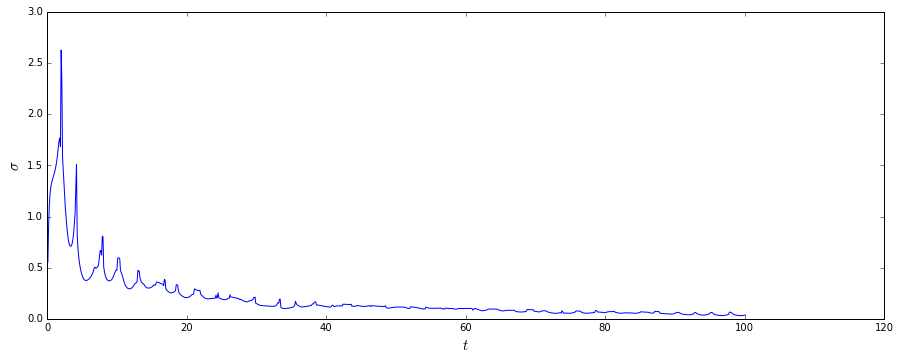

In [209]:
matplotlib.rcParams['figure.figsize'] = (15.0, 5.5)
plt.plot(resultsle1[:,0], (resultsle1[:,1]))
plt.xlabel(r'$t$', fontsize = 15)
plt.ylabel(r'$\sigma$', fontsize = 15)
#plt.xlim(0,1000)
#plt.ylim(0,0.05)

(0, 3)

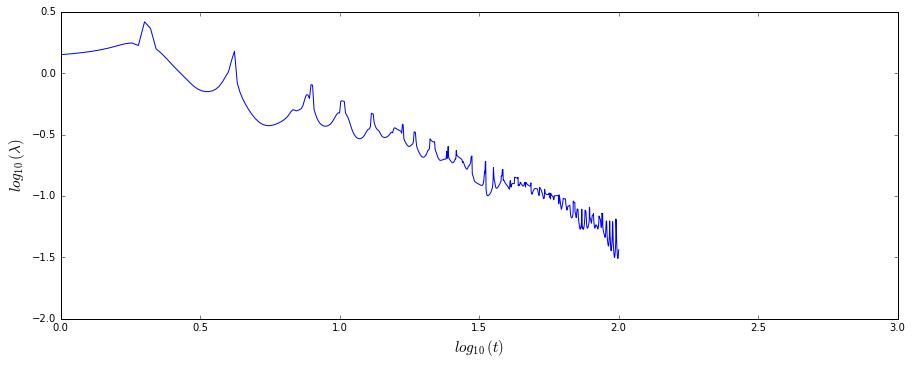

In [210]:
plt.plot(np.log10(resultsle1[:,0]), np.log10(resultsle1[:,1]))
plt.xlabel(r'$log_{10}\,(t)$', fontsize = 15)
plt.ylabel(r'$log_{10}\,(\lambda)$', fontsize = 15)
plt.xlim(0,3)

In [211]:
pmw = FP(amp = 1, a = 8*units.kpc, b = 0.35, c = 0.2375, normalize = True, omegab = 10.*units.km/units.s/units.kpc)
orb = Orbit(vxvv = [1,0.25,0.6,0,0.0,0])
timespan = np.linspace(0,200,2000)
orb.integrate(timespan, pmw, method = 'leapfrog')

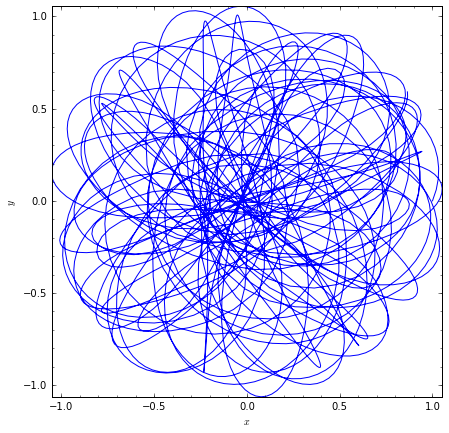

In [212]:
matplotlib.rcParams['figure.figsize'] = (7,7)
orb.plot(d1 = 'x', d2 = 'y')
#plt.xlim(-0.5,0.5)
#plt.ylim(-0.5,0.5)

In [ ]:
%%prun -s cumulative
pmw = FP(amp = 1, a = 8*units.kpc, b = 0.35, c = 0.2375, normalize = True, omegab = 10.*units.km/units.s/units.kpc)
icon = np.array([0.5,0.3,0.3,0.,0.,np.pi/50])
tau = 0.01
Tm = 1000
Gm = 10**-30
resultsle2 = lyapunov(icon, tau, pmw, Tm, Gm)

In [ ]:
matplotlib.rcParams['figure.figsize'] = (15.0, 5.5)
plt.plot(resultsle2[:,0], (resultsle2[:,1]))
plt.xlabel(r'$t$', fontsize = 15)
plt.ylabel(r'$\sigma$', fontsize = 15)
plt.xlim(0,1000)
plt.ylim(0,0.4)

In [ ]:
matplotlib.rcParams['figure.figsize'] = (15.0, 5.5)
plt.plot(np.log10(resultsle2[:,0]), np.log10(resultsle2[:,1]))
plt.xlabel(r'$log_{10}\,(t)$', fontsize = 15)
plt.ylabel(r'$log_{10}\,(\lambda)$', fontsize = 15)
plt.xlim(0,3)

In [ ]:
orb = Orbit(vxvv = [0.5,0.3,0.3,0.,0.,np.pi/50])
timespan = np.linspace(0,200,2000)
orb.integrate(timespan, pmw, method = 'leapfrog')

In [ ]:
matplotlib.rcParams['figure.figsize'] = (7,7)
orb.plot(d1 = 'x', d2 = 'y')

In [ ]:
matplotlib.rcParams['figure.figsize'] = (7,7)

In [ ]:
[xo,yo], [xo1,yo1] = allorbits(xle,yle)
plt.plot(xo[:],yo[:])
plt.plot(xo1[:],yo1[:])

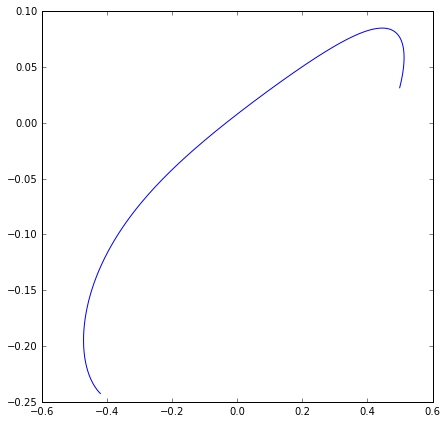

In [200]:
a,b = [],[]
for i in range(2000):
    a.append(orb.x(i/200))
    b.append(orb.y(i/200))
plt.plot(a[:300],b[:300])

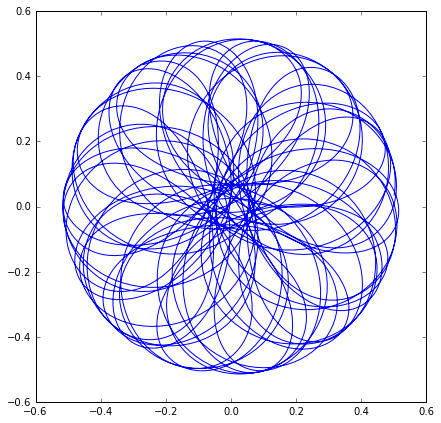

In [192]:
ts = np.linspace(0,300,3000)
aa,bb = inrotframe(xo,yo,ts,pmw)
plt.plot(aa,bb)